In [ ]:
#this code is referenced from the official tutorial

# Object Detection

In this tutorial, you will see how we finetune a model trained with coco dataset, to make it better fit our dataset with the same object classes.

In [1]:
cd mmdetection

/home/test/ml_sample/detection/mm_DINO/mmdetection


/home/test/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import MMDetection

In [2]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

In [3]:
# there are plenty of models
# you may check what models are available on
# https://mmdetection.readthedocs.io/en/latest/modelzoo_statistics.html

In [4]:
!mim download mmdet --config dino-4scale_r50_8xb2-12e_coco --dest ./checkpoint

processing dino-4scale_r50_8xb2-12e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.0/251.0 MiB 23.3 MB/s eta 0:00:00m eta 0:00:010:00:01
Successfully downloaded dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth to /home/test/ml_sample/detection/mm_DINO/mmdetection/checkpoint
Successfully dumped dino-4scale_r50_8xb2-12e_coco.py to /home/test/ml_sample/detection/mm_DINO/mmdetection/checkpoint


The above code downloads weights of a pretrained model <br>
if it was not successful <br>
go to terminal, and run: <br>
conda activate "your environment name" <br>
cd mmdetection <br>
mim download mmdet --config dino-4scale_r50_8xb2-12e_coco --dest ./checkpoint

### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `DetInferencer` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/dev-3.x/mmdet/apis/det_inferencer.py).

## Finetune with customized datasets

In this part, you will know how to finetune a large model like DINO with customized datasets and then test it. We use the voc2012 as an example to describe the whole process.

The basic steps are as below:

1. Download the pretrained model
2. Prepare the customized dataset
3. Prepare a config
4. Train, test, and infer models on the customized dataset.


In [5]:
# load the pre-trained model
from mmdet.apis import init_detector
from mmengine import Config

# Load config file for the model
config_file = './configs/dino/dino-4scale_r50_8xb2-12e_coco.py' # Example config path
config = Config.fromfile(config_file)

# Initialize detector with pre-trained weights, we just downloaded
checkpoint_file = './checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth'  # Pre-trained weights
model = init_detector(config, checkpoint_file, device='cuda')

# Access model metadata
print(model.dataset_meta)

Loads checkpoint by local backend from path: ./checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth
{'classes': ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'), 'palette

### Prepare the customized dataset

The VOC2012 dataset should have been downloaded and placed in mmdetection/data/ <br>
if not, you can download it from http://host.robots.ox.ac.uk/pascal/VOC/voc2012/ <br>

In [8]:
# we use the Pascal VOC 2012
# reformate it and make train test split
import os
import json
import random
import xml.etree.ElementTree as ET
from tqdm import tqdm
from collections import defaultdict

# Config
random.seed(42)
custom_classes = ['bicycle', 'bus', 'car', 'motorbike', 'train']
voc_root = './data/VOC2012/'
ann_dir = os.path.join(voc_root, 'Annotations')
img_dir = os.path.join(voc_root, 'JPEGImages')
output_dir = voc_root
os.makedirs(output_dir, exist_ok=True)

# Validate directories
if not os.path.exists(ann_dir):
    raise FileNotFoundError(f"Annotation directory not found: {ann_dir}")
if not os.path.exists(img_dir):
    raise FileNotFoundError(f"Image directory not found: {img_dir}")

# Get list of available image files
available_images = set(os.listdir(img_dir))

# Category mapping
categories = [{'id': i, 'name': cls} for i, cls in enumerate(custom_classes)]
class_to_id = {cls: i for i, cls in enumerate(custom_classes)}

# Helper data
image_data = {}  # image_id -> image_info
annotation_data = []  # list of all annotations
image_to_classes = defaultdict(set)  # image file -> set of classes in that image
class_to_images = defaultdict(list)  # class -> list of image files containing that class
ann_id = 1
img_id_counter = 1
file_to_img_id = {}

# Step 1: Parse XML and build annotations + class-image map
for filename in tqdm(os.listdir(ann_dir), desc='Parsing annotations'):
    if not filename.endswith('.xml'):
        continue
        
    xml_path = os.path.join(ann_dir, filename)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    file_name = root.find('filename').text
    
    # Handle missing file extension in XML
    if '.' not in file_name:
        possible_extensions = ['.jpg', '.jpeg', '.png']
        for ext in possible_extensions:
            if file_name + ext in available_images:
                file_name = file_name + ext
                break
    
    # Skip if image file doesn't exist
    if file_name not in available_images:
        print(f"Warning: Image {file_name} not found in {img_dir}, skipping")
        continue
        
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    
    has_valid_obj = False
    anns = []
    img_id = img_id_counter
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        if label not in class_to_id:
            continue
            
        has_valid_obj = True
        category_id = class_to_id[label]
        bbox = obj.find('bndbox')
        
        try:
            xmin = max(0, int(float(bbox.find('xmin').text)))
            ymin = max(0, int(float(bbox.find('ymin').text)))
            xmax = min(width, int(float(bbox.find('xmax').text)))
            ymax = min(height, int(float(bbox.find('ymax').text)))
            
            # Skip invalid bounding boxes
            if xmax <= xmin or ymax <= ymin:
                print(f"Warning: Invalid bbox in {file_name}: {xmin},{ymin},{xmax},{ymax}, skipping")
                continue
                
            w = xmax - xmin
            h = ymax - ymin
            
            ann = {
                'id': ann_id,
                'image_id': img_id,
                'category_id': category_id,
                'bbox': [xmin, ymin, w, h],
                'area': w * h,
                'iscrowd': 0
            }
            
            anns.append(ann)
            ann_id += 1
            image_to_classes[file_name].add(label)
            class_to_images[label].append(file_name)
        except (ValueError, TypeError) as e:
            print(f"Error processing bbox in {file_name}: {e}")
            
    if has_valid_obj:
        image_info = {
            'id': img_id,
            'file_name': file_name,
            'width': width,
            'height': height
        }
        image_data[file_name] = image_info
        annotation_data.extend(anns)
        file_to_img_id[file_name] = img_id
        img_id_counter += 1

# Print class distribution
print("Class distribution:")
for cls in custom_classes:
    print(f"  {cls}: {len(class_to_images[cls])} images")

# Step 2: Split images with stratified sampling
all_images = list(file_to_img_id.keys())
random.shuffle(all_images)

# Create a stratified split - first assign each image to either train or test
image_split = {}  # image -> 'train' or 'test'

for img in all_images:
    if img not in image_split:  # if not already assigned
        # 80% train, 20% test
        if random.random() < 0.8:
            image_split[img] = 'train'
        else:
            image_split[img] = 'test'

train_files = [img for img, split in image_split.items() if split == 'train']
test_files = [img for img, split in image_split.items() if split == 'test']

# Verify we have test examples for each class
for cls in custom_classes:
    test_count = sum(1 for img in test_files if cls in image_to_classes[img])
    if test_count == 0:
        # Move one train image with this class to test
        candidates = [img for img in train_files if cls in image_to_classes[img]]
        if candidates:
            img_to_move = random.choice(candidates)
            train_files.remove(img_to_move)
            test_files.append(img_to_move)
            print(f"Moved one '{cls}' image from train to test set for balance")

# Step 3: Create COCO JSON for each split
def create_coco_json(selected_files, image_data, annotation_data):
    used_img_ids = set(file_to_img_id[f] for f in selected_files)
    images = [img for f, img in image_data.items() if f in selected_files]
    annotations = [ann for ann in annotation_data if ann['image_id'] in used_img_ids]
    return {
        'images': images,
        'annotations': annotations,
        'categories': categories
    }

train_json = create_coco_json(train_files, image_data, annotation_data)
test_json = create_coco_json(test_files, image_data, annotation_data)

# Step 4: Save to disk
with open(os.path.join(output_dir, 'voc2012_custom_train.json'), 'w') as f:
    json.dump(train_json, f)
    
with open(os.path.join(output_dir, 'voc2012_custom_test.json'), 'w') as f:
    json.dump(test_json, f)

# Print summary statistics
print("\nTrain/Test split completed:")
print(f"  Train images: {len(train_json['images'])}")
print(f"  Test images:  {len(test_json['images'])}")

# Print class distribution in train and test sets
print("\nClass distribution in splits:")
for cls in custom_classes:
    train_count = sum(1 for img in train_files if cls in image_to_classes[img])
    test_count = sum(1 for img in test_files if cls in image_to_classes[img])
    train_pct = train_count / (train_count + test_count) * 100 if (train_count + test_count) > 0 else 0
    print(f"  {cls}: {train_count} train ({train_pct:.1f}%), {test_count} test")

Parsing annotations: 100%|█████████████| 17125/17125 [00:00<00:00, 29680.68it/s]


Class distribution:
  bicycle: 837 images
  bus: 685 images
  car: 2492 images
  motorbike: 801 images
  train: 704 images

Train/Test split completed:
  Train images: 2483
  Test images:  591

Class distribution in splits:
  bicycle: 491 train (81.4%), 112 test
  bus: 374 train (80.1%), 93 test
  car: 1037 train (80.8%), 247 test
  motorbike: 456 train (79.3%), 119 test
  train: 479 train (81.3%), 110 test


In [9]:
# suppose we only need our model to detect 'bicycle', 'bus', 'car', 'motorcycle', 'train'
# we trim the model
import torch
import numpy as np
from mmengine import Config
from mmdet.apis import init_detector
from mmdet.utils import register_all_modules
import os

# Register all modules for proper functioning
register_all_modules()

def trim_dino_model(
    config_file,
    checkpoint_file,
    target_classes,
    output_dir='./trimmed_model',
    device='cuda'
):
    """
    Trim a DINO model to only include the specified target classes.
    
    Args:
        config_file (str): Path to the original DINO config file
        checkpoint_file (str): Path to the original DINO checkpoint file
        target_classes (list): List of class names to keep
        output_dir (str): Directory to save trimmed model and config
        device (str): Device to use ('cuda' or 'cpu')
        
    Returns:
        tuple: Paths to the trimmed config file and checkpoint file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load your pretrained model
    model = init_detector(config_file, checkpoint_file, device=device)
    config = Config.fromfile(config_file)
    
    # Step 1: Get the original COCO class list and find indices of target classes
    coco_classes = model.dataset_meta['classes']
    print(f"Original model has {len(coco_classes)} classes")
    
    # Map target classes to their indices in COCO
    target_indices = []
    for cls in target_classes:
        if cls in coco_classes:
            idx = coco_classes.index(cls)
            target_indices.append(idx)
        else:
            print(f"Warning: Class '{cls}' not found in original classes")
    
    print(f"Target class indices: {target_indices}")
    
    # Step 2: Trim the classification head of the model
    # First, examine the model structure
    print("Model bbox_head structure:", type(model.bbox_head))
    
    # Modify classification branches (for DINO model)
    if hasattr(model.bbox_head, 'cls_branches'):
        num_layers = len(model.bbox_head.cls_branches)
        print(f"Found {num_layers} classification branches")
        
        for layer_idx in range(num_layers):
            # Get the current classification branch (Linear layer)
            cls_branch = model.bbox_head.cls_branches[layer_idx]
            
            # Extract original weights and biases
            original_weight = cls_branch.weight.data
            original_bias = cls_branch.bias.data
            
            # Create new weights and biases for target classes
            new_num_classes = len(target_indices)
            new_weight = torch.zeros(new_num_classes, original_weight.shape[1], device=original_weight.device)
            new_bias = torch.zeros(new_num_classes, device=original_bias.device)
            
            # Copy weights and biases for target classes
            for i, idx in enumerate(target_indices):
                new_weight[i] = original_weight[idx]
                new_bias[i] = original_bias[idx]
                
            # Create a new linear layer with updated weights
            in_features = cls_branch.in_features
            new_cls_branch = torch.nn.Linear(in_features, new_num_classes)
            new_cls_branch.weight.data = new_weight
            new_cls_branch.bias.data = new_bias
            
            # Replace the original classification branch with the new one
            model.bbox_head.cls_branches[layer_idx] = new_cls_branch
    
    # Update model's metadata
    model.dataset_meta['classes'] = target_classes
    model.bbox_head.num_classes = len(target_classes)
    
    # Handle regression branches if they are class-specific
    if hasattr(model.bbox_head, 'reg_branches'):
        num_reg_layers = len(model.bbox_head.reg_branches)
        print(f"Found {num_reg_layers} regression branches")
        
        for layer_idx in range(num_reg_layers):
            reg_branch = model.bbox_head.reg_branches[layer_idx]
            
            # For Sequential modules, we need to check the last layer
            if isinstance(reg_branch, torch.nn.Sequential):
                # Find the last Linear layer in the Sequential
                last_linear = None
                for module in reg_branch:
                    if isinstance(module, torch.nn.Linear):
                        last_linear = module
                
                if last_linear is not None:
                    # Check if the output dimension is class-specific
                    if last_linear.out_features % 4 == 0:  # 4 coordinates per box
                        orig_classes = last_linear.out_features // 4
                        
                        if orig_classes == model.bbox_head.num_classes or orig_classes == len(coco_classes):
                            print(f"Modifying regression branch {layer_idx}")
                            # This regression branch is class-specific and needs updating
                            original_weight = last_linear.weight.data
                            original_bias = last_linear.bias.data
                            
                            in_features = last_linear.in_features
                            out_features = len(target_indices) * 4  # 4 coordinates per class
                            
                            new_linear = torch.nn.Linear(in_features, out_features)
                            
                            # Extract weights and biases for target classes
                            new_weight = torch.zeros(out_features, in_features, device=original_weight.device)
                            new_bias = torch.zeros(out_features, device=original_bias.device)
                            
                            for i, idx in enumerate(target_indices):
                                # For each target class, copy the 4 bbox coordinate weights
                                src_start = idx * 4
                                dst_start = i * 4
                                new_weight[dst_start:dst_start+4] = original_weight[src_start:src_start+4]
                                new_bias[dst_start:dst_start+4] = original_bias[src_start:src_start+4]
                                
                            new_linear.weight.data = new_weight
                            new_linear.bias.data = new_bias
                            
                            # Replace the last layer in the Sequential with our new one
                            modules_list = list(reg_branch.children())
                            for i, module in enumerate(modules_list):
                                if module is last_linear:
                                    modules_list[i] = new_linear
                                    break
                            
                            # Create a new Sequential with updated modules
                            new_reg_branch = torch.nn.Sequential(*modules_list)
                            model.bbox_head.reg_branches[layer_idx] = new_reg_branch

    # === Update dn_query_generator.label_embedding ===
    if hasattr(model, 'dn_query_generator') and hasattr(model.dn_query_generator, 'label_embedding'):
        old_emb = model.dn_query_generator.label_embedding.weight.data
        new_num_classes = len(target_indices)
        emb_dim = old_emb.shape[1]
    
        new_emb = torch.zeros((new_num_classes, emb_dim), device=old_emb.device)
        for i, idx in enumerate(target_indices):
            new_emb[i] = old_emb[idx]
        
        # Create a new Embedding layer
        model.dn_query_generator.label_embedding = torch.nn.Embedding(new_num_classes, emb_dim).to(old_emb.device)
        model.dn_query_generator.label_embedding.weight.data = new_emb
    
    print(f"Model trimmed to {len(target_classes)} classes: {target_classes}")
    
    # Step 3: Update the config for inference
    finetune_config = config.copy()
    
    # Update model configuration
    finetune_config.model.bbox_head.num_classes = len(target_classes)
    finetune_config.model.pop('init_cfg', None)  # Remove pretrained info (optional)

    # Step 4: Save the trimmed model checkpoint and config
    # Create a MMDetection-compatible checkpoint with proper metadata
    mmdet_checkpoint = {
        'meta': {
            'epoch': 0,
            'iter': 0,
            'version': '3.3.0',  # Use your MMDetection version
            'task': 'ObjectDetection',
            'dataset_meta': {
                'classes': target_classes,
                'palette': None,  # You can add palette if needed
                'version': '1.0'
            }
        },
        'state_dict': model.state_dict()
    }
    
    # Save paths
    config_path = os.path.join(output_dir, 'trimmed_dino_config.py')
    checkpoint_path = os.path.join(output_dir, 'trimmed_dino_checkpoint.pth')
    
    # Save checkpoint
    torch.save(mmdet_checkpoint, checkpoint_path)
    
    # Save config
    finetune_config.dump(config_path)
    
    print(f"Trimmed model saved to '{checkpoint_path}'")
    print(f"Trimmed config saved to '{config_path}'")
    
    return config_path, checkpoint_path

if __name__ == "__main__":
    # Original model paths
    config_file = './configs/dino/dino-4scale_r50_8xb2-12e_coco.py' # Example config path
    checkpoint_file = './checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth'  # Pre-trained weights
    
    # Define target classes
    target_classes = ['bicycle', 'bus', 'car', 'motorcycle', 'train']
    
    # Trim the model
    config_path, checkpoint_path = trim_dino_model(
        config_file,
        checkpoint_file,
        target_classes,
        output_dir='./trimmed_model',
        device='cuda'  # Use 'cpu' if no GPU available
    )

Loads checkpoint by local backend from path: ./checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth
Original model has 80 classes
Target class indices: [1, 5, 2, 3, 6]
Model bbox_head structure: <class 'mmdet.models.dense_heads.dino_head.DINOHead'>
Found 7 classification branches
Found 7 regression branches
Model trimmed to 5 classes: ['bicycle', 'bus', 'car', 'motorcycle', 'train']
Trimmed model saved to './trimmed_model/trimmed_dino_checkpoint.pth'
Trimmed config saved to './trimmed_model/trimmed_dino_config.py'


Loads checkpoint by local backend from path: ./checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth


Output()

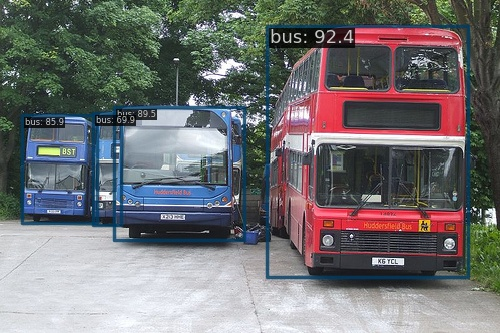

In [10]:
# test the non-trimmed model
from mmdet.apis import DetInferencer

config_file = './configs/dino/dino-4scale_r50_8xb2-12e_coco.py' # Example config path
checkpoint_file = './checkpoint/dino-4scale_r50_8xb2-12e_coco_20221202_182705-55b2bba2.pth'  # Pre-trained weights
device = 'cuda' # cpu or cuda
inferencer = DetInferencer(config_file, checkpoint_file, device)
# Use the detector to do inference, 
img = './data/VOC2012/JPEGImages/2009_003757.jpg'
result = inferencer(img, out_dir='./output', pred_score_thr=0.5)
# Show the output image
from PIL import Image
Image.open('./output/vis/2009_003757.jpg')

Loads checkpoint by local backend from path: ./trimmed_model/trimmed_dino_checkpoint.pth


Output()

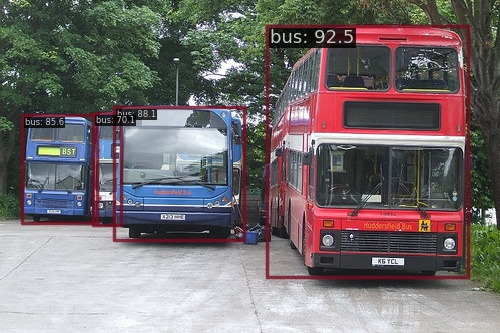

In [11]:
# test the trimmed model
from mmdet.apis import DetInferencer

config_file = './trimmed_model/trimmed_dino_config.py'
checkpoint_file = './trimmed_model/trimmed_dino_checkpoint.pth'
inferencer = DetInferencer(config_file, checkpoint_file, device='cuda')

img = './data/VOC2012/JPEGImages/2009_003757.jpg'
result = inferencer(img, out_dir='./output', pred_score_thr=0.5)
# Show the output image
from PIL import Image
Image.open('./output/vis/2009_003757.jpg')

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [12]:
from mmengine import Config
cfg = Config.fromfile('./trimmed_model/trimmed_dino_config.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
auto_scale_lr = dict(base_batch_size=16)
backend_args = None
data_root = 'data/coco/'
dataset_type = 'CocoDataset'
default_hooks = dict(
    checkpoint=dict(interval=1, type='CheckpointHook'),
    logger=dict(interval=50, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='DetVisualizationHook'))
default_scope = 'mmdet'
env_cfg = dict(
    cudnn_benchmark=False,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
load_from = None
log_level = 'INFO'
log_processor = dict(by_epoch=True, type='LogProcessor', window_size=50)
max_epochs = 12
model = dict(
    as_two_stage=True,
    backbone=dict(
        depth=50,
        frozen_stages=1,
        init_cfg=dict(checkpoint='torchvision://resnet50', type='Pretrained'),
        norm_cfg=dict(requires_grad=False, type='BN'),
        norm_eval=True,
        

In [13]:
from mmengine.runner import set_random_seed

# Modify dataset classes and color
cfg.metainfo = {
    'classes': ('bicycle', 'bus', 'car', 'motorbike', 'train'), # names of classes
}

# Modify dataset type and path
cfg.data_root = 'data/VOC2012/'

cfg.train_dataloader.dataset.ann_file = 'voc2012_custom_train.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'JPEGImages/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'voc2012_custom_test.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'JPEGImages/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader

# Modify metric config
cfg.val_evaluator.ann_file = cfg.data_root+'voc2012_custom_test.json'
cfg.test_evaluator = cfg.val_evaluator

# We can use the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = './trimmed_model/trimmed_dino_checkpoint.pth'
cfg.pretrained = None
cfg.model.backbone.init_cfg = None

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.auto_scale_lr.base_batch_size=2
cfg.optim_wrapper.optimizer.lr = 0.0001/8
# Set less epochs
cfg.max_epochs = 4
cfg.train_cfg.max_epochs = 4

# Set seed thus the results are more reproducible
# cfg.seed = 0
set_random_seed(0, deterministic=False)

# We can also use tensorboard to log the training process
cfg.visualizer.vis_backends.append({"type":'TensorboardVisBackend'})

#------------------------------------------------------
config=f'./configs/dino/dino-4scale_r50_8xb2-12e_voc.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

Start training

In [14]:
%run tools/train.py {config}

06/04 16:20:54 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 209652396
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

/home/test/ml_sample/detection/mm_DINO/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
06/04 16:20:55 - mmengine - WARNING - backbone.conv1.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.bn1.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.bn1.bias is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.conv1.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.bn1.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.bn1.bias is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.conv2.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.bn2.weight is skipped since its requires_grad=False
06/04 16:20:55 - mmengine - WARNING - backbone.layer1.0.bn2.bias is skipped si

In [15]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [16]:
import os

def get_latest_checkpoint(base_dir):
    ckpt_file = os.path.join(base_dir, "last_checkpoint")
    if os.path.exists(ckpt_file):
        with open(ckpt_file, "r") as f:
            relative_ckpt_path = f.readline().strip()
            full_ckpt_path = os.path.join(base_dir, relative_ckpt_path)
            if os.path.exists(full_ckpt_path):
                return full_ckpt_path
            else:
                print(f"[Warning] Checkpoint not found: {full_ckpt_path}")
    else:
        print(f"[Error] File not found: {ckpt_file}")

    return None


latest_ckpt = get_latest_checkpoint("tutorial_exps")
print(f"Using checkpoint: {latest_ckpt}")


Using checkpoint: /home/test/ml_sample/detection/mm_DINO/mmdetection/tutorial_exps/epoch_4.pth


Compare the model before and after finetuning, we can see finetuning makes it a little bit better for our new dataset.

In [17]:
%run tools/test.py tutorial_exps/dino-4scale_r50_8xb2-12e_voc.py trimmed_model/trimmed_dino_checkpoint.pth

06/04 16:39:44 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 2087557356
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,c

/home/test/ml_sample/detection/mm_DINO/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loads checkpoint by local backend from path: trimmed_model/trimmed_dino_checkpoint.pth
06/04 16:40:07 - mmengine - INFO - Load checkpoint from trimmed_model/trimmed_dino_checkpoint.pth
06/04 16:40:09 - mmengine - INFO - Epoch(test) [ 50/591]    eta: 0:00:22  time: 0.0409  data_time: 0.0043  memory: 1248  
06/04 16:40:11 - mmengine - INFO - Epoch(test) [100/591]    eta: 0:00:19  time: 0.0374  data_time: 0.0018  memory: 870  
06/04 16:40:13 - mmengine - INFO - Epoch(test) [150/591]    eta: 0:00:17  time: 0.0383  data_time: 0.0017  memory: 883  
06/04 16:40:14 - mmengine - INFO - Epoch(test) [200/591]    eta: 0:00:15  time: 0.0375  data_time: 0.0017  memory: 874  
06/04 16:40:16 - mmengine - INFO - Epoch(test) [250/591]    eta: 0:00:13  time: 0.0372  data_time: 0.0017  memory: 874  
06/04 16:40:18 - mmengine - INFO - Epoch(te

In [18]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [21]:
%run tools/test.py tutorial_exps/dino-4scale_r50_8xb2-12e_voc.py {latest_ckpt} --out output/dino-4scale_r50_8xb2-12e_voc.pkl

06/04 16:41:39 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 961990378
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8/
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,co

/home/test/ml_sample/detection/mm_DINO/mmengine/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


06/04 16:41:50 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/04 16:41:50 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [22]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [23]:
# convert the pkl to json for plotting
import pickle
import json
import torch
import numpy as np

CONF_THRESHOLD = 0.01  # Set your desired threshold here

# Load predictions
print("Loading predictions...")
with open('output/dino-4scale_r50_8xb2-12e_voc.pkl', 'rb') as f:
    predictions = pickle.load(f)

# Print some debug info about the predictions
print(f"Loaded {len(predictions)} predictions")
print(f"First prediction structure: {type(predictions[0])}")

# Process the first prediction to understand its structure
sample = predictions[0]
print("\nSample prediction keys:", sample.keys() if isinstance(sample, dict) else "Not a dictionary")

if isinstance(sample, dict) and 'pred_instances' in sample:
    print("pred_instances keys:", sample['pred_instances'].keys())

    # Check if bboxes is a tensor
    if 'bboxes' in sample['pred_instances']:
        bbox_type = type(sample['pred_instances']['bboxes'])
        print(f"bboxes type: {bbox_type}")

        # If it's a tensor, check if tolist() method exists
        if hasattr(sample['pred_instances']['bboxes'], 'tolist'):
            print("bboxes has tolist() method")
        else:
            print("bboxes does NOT have tolist() method")

# Flattened output with proper error handling
output = []
for i, pred in enumerate(predictions):
    try:
        image_id = pred['img_id']

        if 'pred_instances' in pred:
            instances = pred['pred_instances']

            if all(k in instances for k in ['bboxes', 'labels', 'scores']):
                bboxes = instances['bboxes']
                labels = instances['labels']
                scores = instances['scores']

                if torch.is_tensor(bboxes):
                    bboxes = bboxes.numpy()
                if torch.is_tensor(labels):
                    labels = labels.numpy()
                if torch.is_tensor(scores):
                    scores = scores.numpy()

                for bbox, label, score in zip(bboxes, labels, scores):
                    if score >= CONF_THRESHOLD:
                        # Convert to list if needed
                        if not isinstance(bbox, list):
                            if hasattr(bbox, 'tolist'):
                                bbox = bbox.tolist()
                            else:
                                bbox = list(bbox)

                        # Convert [x1, y1, x2, y2] -> [x, y, width, height]
                        x1, y1, x2, y2 = bbox
                        width = x2 - x1
                        height = y2 - y1
                        coco_bbox = [float(x1), float(y1), float(width), float(height)]

                        output.append({
                            "image_id": int(image_id),
                            "category_id": int(label),
                            "bbox": coco_bbox,
                            "score": float(score)
                        })
    except Exception as e:
        print(f"Error processing prediction {i}: {e}")
        continue

# Verify output integrity
if output:
    print("\nSample output entry:")
    print(json.dumps(output[0], indent=2))

# Save to JSON
with open('coco_style_predictions.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"Saved {len(output)} predictions above {CONF_THRESHOLD} confidence to 'coco_style_predictions.json'")


Loading predictions...
Loaded 591 predictions
First prediction structure: <class 'dict'>

Sample prediction keys: dict_keys(['img_path', 'pad_shape', 'img_id', 'ori_shape', 'batch_input_shape', 'scale_factor', 'img_shape', 'pred_instances'])
pred_instances keys: dict_keys(['scores', 'labels', 'bboxes'])
bboxes type: <class 'torch.Tensor'>
bboxes has tolist() method

Sample output entry:
{
  "image_id": 8,
  "category_id": 1,
  "bbox": [
    266.9793395996094,
    24.949569702148438,
    204.20477294921875,
    252.91233825683594
  ],
  "score": 0.9230695962905884
}
Saved 84855 predictions above 0.01 confidence to 'coco_style_predictions.json'


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


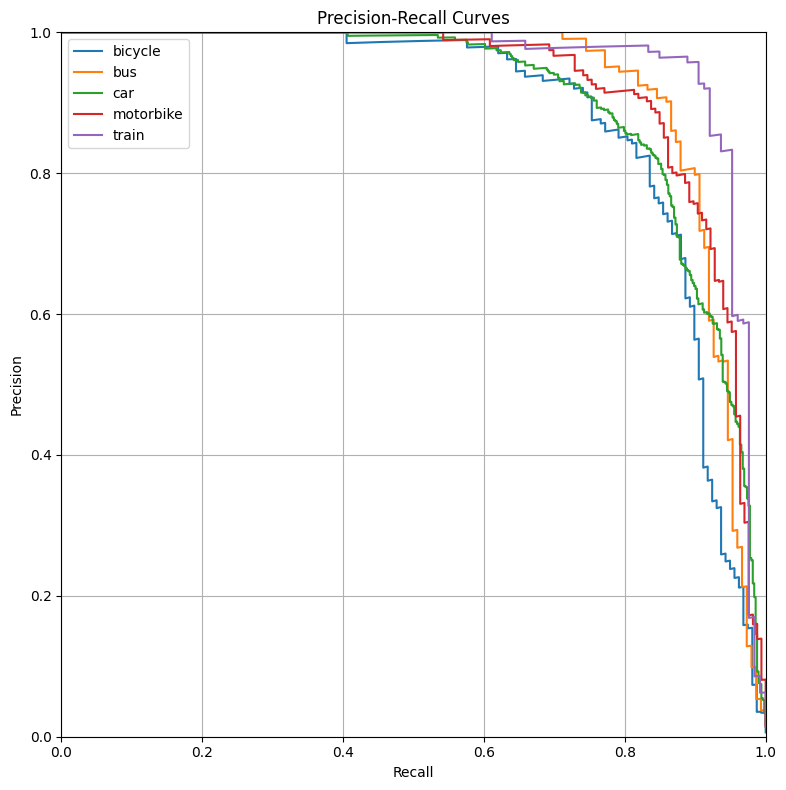

In [24]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Paths
truth_json = "data/VOC2012/voc2012_custom_test.json"
pred_json = "coco_style_predictions.json"

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Build category mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions and GT annotations by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

# Helper to compute IoU between two boxes
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

# Compute precision-recall curves
iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    # Check if enough variation to compute curve
    if len(set(y_true)) < 2:
        print(f"Skipping {cat_id_to_name[cat_id]}: Not enough positives/negatives.")
        continue

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall
    }

# ---- Plot Precision-Recall Curves ----
plt.figure(figsize=(10, 8))

for cat_id, data in class_curves.items():
    plt.plot(data['recall'], data['precision'], label=cat_id_to_name[cat_id])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
#plt.savefig('precision_recall_curves.png', bbox_inches='tight', dpi=300)
plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


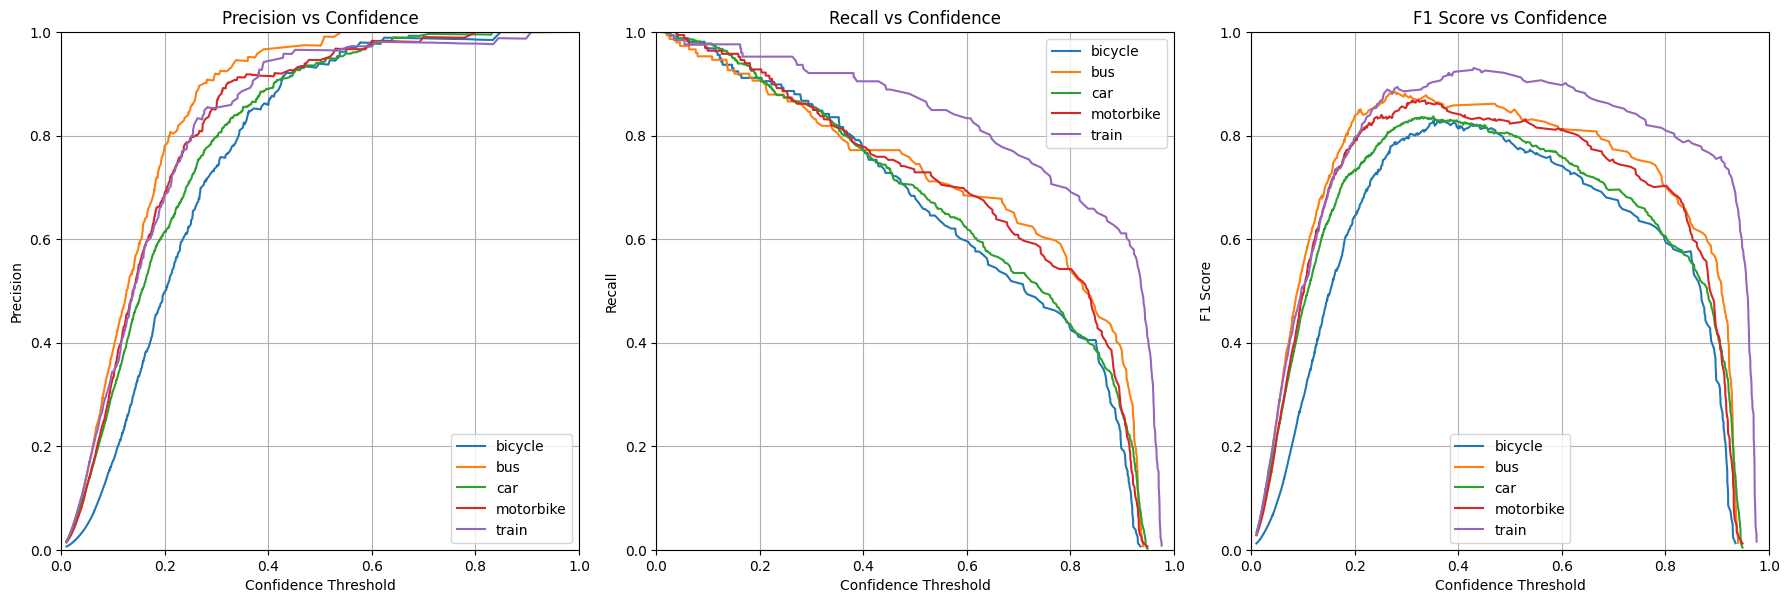

In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict
from sklearn.metrics import precision_recall_curve

# Load annotations and predictions
truth_json = "data/VOC2012/voc2012_custom_test.json"
pred_json = "coco_style_predictions.json"

# Load COCO GT and prediction JSONs
coco_gt = COCO(truth_json)
with open(pred_json, 'r') as f:
    predictions = json.load(f)

# Get category ID to name mapping
categories = coco_gt.loadCats(coco_gt.getCatIds())
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
cat_ids = list(cat_id_to_name.keys())

# Group predictions by category
preds_by_cat = defaultdict(list)
for pred in predictions:
    preds_by_cat[pred['category_id']].append(pred)

# Group GT annotations by category
gt_by_cat = defaultdict(list)
for ann in coco_gt.dataset['annotations']:
    gt_by_cat[ann['category_id']].append(ann)

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    return interArea / (boxAArea + boxBArea - interArea + 1e-6)

iou_threshold = 0.5
class_curves = {}

for cat_id in cat_ids:
    y_true = []
    y_scores = []

    preds = sorted(preds_by_cat[cat_id], key=lambda x: -x['score'])
    gt_annots = gt_by_cat[cat_id]
    used = set()

    for pred in preds:
        pred_box = pred['bbox']
        image_id = pred['image_id']
        matched = False

        for gt in gt_annots:
            if gt['image_id'] != image_id or gt['id'] in used:
                continue
            iou = compute_iou(pred_box, gt['bbox'])
            if iou >= iou_threshold:
                matched = True
                used.add(gt['id'])
                break

        y_true.append(1 if matched else 0)
        y_scores.append(pred['score'])

    if len(set(y_true)) < 2:
        if sum(y_true) == 0:
            print(f"Class {cat_id_to_name[cat_id]} has ALL FALSE POSITIVES (no TP).")
        else:
            print(f"Class {cat_id_to_name[cat_id]} has ALL TRUE POSITIVES (no FP).")
        continue

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    class_curves[cat_id] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds
    }

# Plotting
plt.figure(figsize=(18, 6))

# 1. Precision-Confidence
plt.subplot(1, 3, 1)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['precision'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 2. Recall-Confidence
plt.subplot(1, 3, 2)
for cat_id, data in class_curves.items():
    plt.plot(data['thresholds'], data['recall'][:-1], 
             label=cat_id_to_name[cat_id])
plt.xlabel('Confidence Threshold')
plt.ylabel('Recall')
plt.title('Recall vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()

# 3. NEW: F1-Confidence
plt.subplot(1, 3, 3)
for cat_id, data in class_curves.items():
    # Calculate F1 scores
    precision = data['precision'][:-1]
    recall = data['recall'][:-1]
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    
    plt.plot(data['thresholds'], f1_scores, 
             label=cat_id_to_name[cat_id])

plt.xlabel('Confidence Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Confidence')
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.tight_layout()
#plt.savefig('precision_recall_f1_confidence.png', bbox_inches='tight', dpi=300)
plt.show()

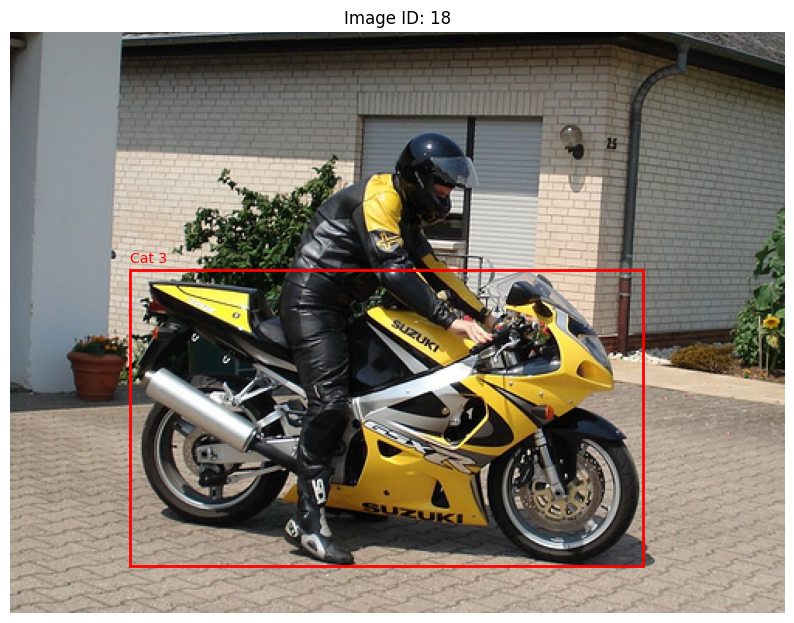

In [36]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Paths
truth_json = "data/VOC2012/voc2012_custom_test.json"
img_folder = "data/VOC2012/JPEGImages"

# Load annotation JSON
with open(truth_json, 'r') as f:
    coco = json.load(f)

# Get one image
first_image = coco['images'][2] #2 is the image index, you can set any number
image_id = first_image['id']
image_filename = first_image['file_name']
image_path = os.path.join(img_folder, image_filename)

# Load and plot image
image = Image.open(image_path)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image)
ax.set_title(f"Image ID: {image_id}")

# Draw ground-truth boxes
for ann in coco['annotations']:
    if ann['image_id'] == image_id:
        #print(ann)
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Cat {ann['category_id']}", color='red', fontsize=10)

plt.axis('off')
plt.show()


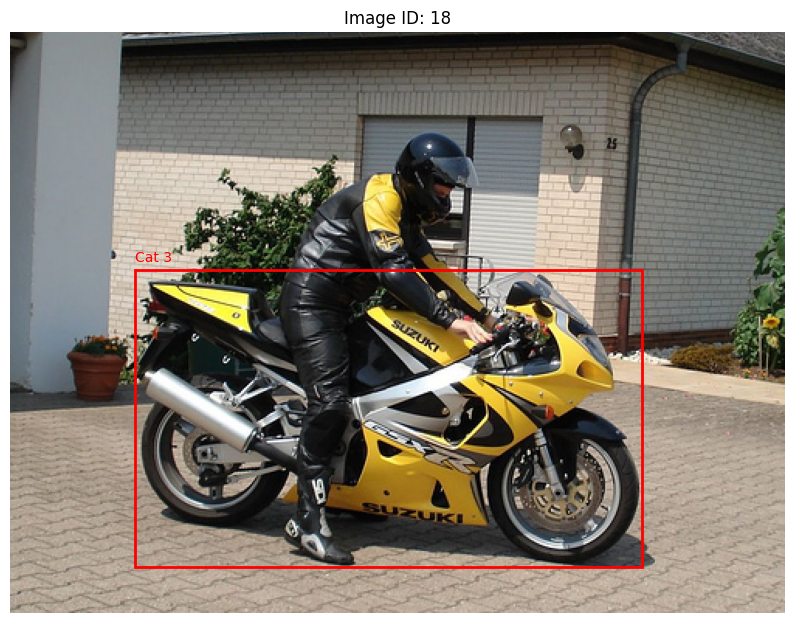

In [37]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Paths
truth_json = "coco_style_predictions.json"

# Load annotation JSON
with open(truth_json, 'r') as f:
    coco = json.load(f)

# Load and plot image
image = Image.open(image_path)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(image)
ax.set_title(f"Image ID: {image_id}")

# Draw ground-truth boxes
threshold = 0.5
for ann in coco:
    if ann['image_id'] == image_id and ann['score']>threshold:
        #print(ann['bbox'])
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"Cat {ann['category_id']}", color='red', fontsize=10)

plt.axis('off')
plt.show()


# Export 
Currently MMdeploy does not support exporting DINO to other backends yet.
If you need model to export, please refer to https://mmdeploy.readthedocs.io/en/latest/03-benchmark/supported_models.html